.ipynb settings

In [30]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/

import useful_functions

Importation of the dataset(s)

In [32]:
#Importing dataset(s)
from data import make_dataset

#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')

X_test_00   = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00   = make_dataset.load_data(False, 'processed/split/Y_test_00')

#Load the not_split train and test datasets:
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# VI) <u> Pipeline development 

<span style="color:#FF1493;"> <strong> <font size="4">1) Pipeline and GridSearchCV implementation

In [33]:

# --------------------------------------------------------------
# Correlated features remover (not used)
# --------------------------------------------------------------

from features import features_selection
from configuration import constant_variables


#Correlated features remover definition (it's a transformer)
corr_features_selector = features_selection.correlated_features_removal_transformer(corr_threshold = 0.95)


# --------------------------------------------------------------
# Features selector
# --------------------------------------------------------------

"""
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model_sfs = LogisticRegression(max_iter=10000, C = 0.3, random_state =33, penalty = 'l2')
sequ_feat_selector = SFS(estimator = model_sfs, k_features = 'best', forward = True, verbose = 0, cv=constant_variables.CV, scoring = 'neg_log_loss', n_jobs = -1)
"""

#OU

#Filter features selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
filter_feat_selector = SelectKBest(f_classif, k= 10)

# --------------------------------------------------------------
# Scaler
# --------------------------------------------------------------

from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()


# --------------------------------------------------------------
# Model
# --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l1', fit_intercept=True, random_state = 999, solver = 'saga', max_iter= 3000, verbose = False, tol=1e-4)

# --------------------------------------------------------------
# Pipeline
# --------------------------------------------------------------
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[("scaler",scaler), ("features_selector",filter_feat_selector), ("model", model)])


#parameters to optimize definition
import numpy as np
parameters = {'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
             'model__C': np.logspace(-3, 1, 21),
             'model__solver': ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs'],
             'features_selector__k' : [5,8,10,12,15,17]
             }

# --------------------------------------------------------------
# GridSearchCV
# --------------------------------------------------------------
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV
from configuration import constant_variables

grid_search = GridSearchCV(pipeline, parameters, cv=constant_variables.CV, scoring = 'neg_log_loss', verbose=0)
# Fit the GridSearchCV to the data
grid_search.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())




c:\Users\polol\anaconda3\envs\env-projet-mbappe\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
8925 fits failed out of a total of 12600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
525 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\anaconda3\envs\env-projet-mbappe\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\anaconda3\envs\env-projet-mbappe\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\anaconda3\envs\env-pr

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('features_selector', SelectKBest()),
                                       ('model',
                                        LogisticRegression(max_iter=3000,
                                                           penalty='l1',
                                                           random_state=999,
                                                           solver='saga',
                                                           verbose=False))]),
             param_grid={'features_selector__k': [5, 8, 10, 12, 15, 17],
                         'model__C': array([1.00000000e-...
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30957344e-02, 1.00000000e-01, 1.58489319e-01,
       2.51188643e-01, 3.98107171e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'model__solver': ['saga', 'sag', 'liblinear',
                                           'newton-cg', 'lbfgs']},
             scoring='neg_log_loss')

<span style="color:#808080;"> <strong> <font size="4">2) Model calibration (Not used fot LR)

In [34]:

#definition of a calibrator
"""
from sklearn.calibration import CalibratedClassifierCV
calibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)
calibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())
"""


"\nfrom sklearn.calibration import CalibratedClassifierCV\ncalibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)\ncalibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())\n"

<span style="color:#FF1493;"> <strong> <font size="4">3) Display GridSearchCV results

Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=12)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, solver='saga',
                                    verbose=False))])
Best Parameters: {'features_selector__k': 12, 'model__C': 0.025118864315095808, 'model__penalty': 'l2', 'model__solver': 'saga'} 

Best score with these hyper parameters: -0.5876294425804882


Features selected: Index(['Diff_Avg_points_pm_ponderated_by_adversary_perf', 'Diff_Avg_goal_diff',
       'Diff_Avg_scored_g_conceeded_g_ratio', 'Diff_Avg_collected_points',
       'Diff_Annual_budget', 'Diff_Points_5lm', 'Diff_Goal_Diff_5lm',
       'Diff_Avg_shots_nb', 'Diff_Avg_shots_on_target_nb',
       'Diff_Avg_possession', 'Diff_Avg_xg', 'H_A_status'],
      dtype='object')
(2188,)
[0 1]
(2188, 7)


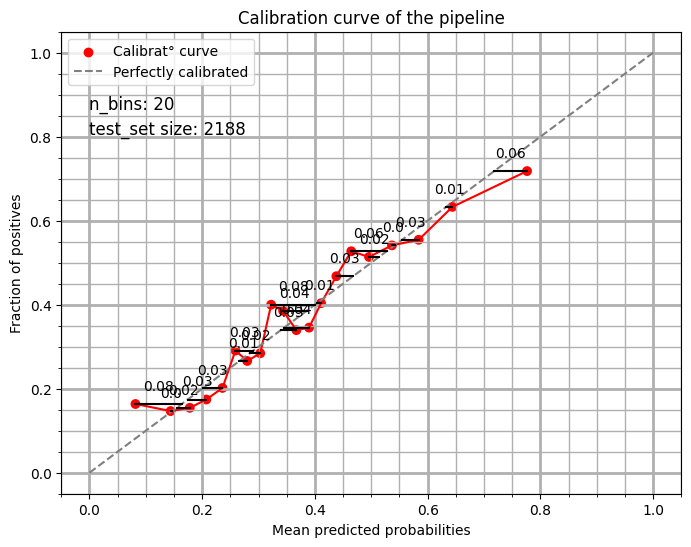

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.12]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.12, 0.16]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.16, 0.2]    │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.2, 0.22]    │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.22, 0.25]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.25, 0.27]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.27, 0.29]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.29, 0.31]   │                 

In [57]:
#src.pipeline.results

from sklearn.base import clone

from pipeline import results

# On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_

# We print the results of GridSearchCV() execution
print(chosen_pipeline)
results.GridSearchCV_results(grid_search, X_train_00.copy())


# Plot Calibration curve for the pipeline build by GridSearchCV
test_seasons = [2021,2022,2023,2024]

# Make proba predictions retraining the pipeline at every Game Week or every Season:
proba_predicted_GW_training, Y_test_GW_training, X_info_test_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(chosen_pipeline), 'week', test_seasons)

print(proba_predicted_GW_training.shape)
print(Y_test_GW_training['Result'].unique())
print(X_info_test_GW_training.shape)

#Plot Calibration curve of the pipeline and info about its bins
prob_pred_01, prob_true_01 = results.plot_calibration_curve_2(
                                Y_test_0 = Y_test_GW_training.copy(),
                                X_train_0 = X_info_test_GW_training.copy(),
                                proba_pred_0 = proba_predicted_GW_training.copy(),
                                n_bins_0 = 20,
                                strategy_0 = 'quantile',
                                color_0 = 'red',
                                GW_training_or_not = True,
                                )

#We display statistics on the pipeline probabilities deviation 
results.print_calibration_stats(prob_pred_01.copy(),
                                prob_true_01.copy(),
                                'non calibrated')

<span style="color:#FF1493;"> <strong> <font size="4">4) Pipeline and dataframes Saving


In [ ]:
#src.pipeline.model
from pipeline import model
from features.features_selection import restricted_datasets


"""
#On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_
print(chosen_pipeline)

X_train_01 = X_train_00.copy()
X_test_01 = X_test_00.copy()

chosen_pipeline_trained = chosen_pipeline.fit(X_train_01.copy(), Y_train_00.copy().values.ravel())
"""



In [ ]:
#src.pipeline.model #src.data.make_dataset
#Save the trained pipeline

model.save_pipeline(chosen_pipeline_trained, "chosen_pipeline_trained")
model.save_pipeline(chosen_pipeline, "chosen_pipeline")

#Saving dataset(s)
from data import make_dataset

#Load the feat_engineered_ds:
make_dataset.save_dataframe(X_train_01, 'processed/X_train_01')
make_dataset.save_dataframe(X_test_01, 'processed/X_test_01')


No old pipeline to delete at:              chosen_pipeline_trained
Successfully saved the new pipeline:       chosen_pipeline_trained


No old pipeline to delete at:              chosen_pipeline
Successfully saved the new pipeline:       chosen_pipeline


The dataframes ARE the same for both old and new processed/X_train_01
Successfully deleted the old file:               processed/X_train_01
Successfully saved the new dataframe:            processed/X_train_01


The dataframes ARE the same for both old and new processed/X_test_01
Successfully deleted the old file:               processed/X_test_01
Successfully saved the new dataframe:            processed/X_test_01


